# NMDA EPSP/EPSC simulation using multisynapse

In [1]:
# loading libraries
import nest
import numpy as np
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Sep 12 2022 04:40:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Comparing two cases with different NMDA/AMPA ratios

As an example, we will create two neurons with different NMDA to AMPA ratios and show their EPSPs. 

- neuron1 with r_NMDA = 1.5
- neuron2 with r_NMDA = 4.0 

In [2]:
# PSC over PSP conversion
def psc_over_psp(C_m, tau_m, tau_syn):
    
    eps = tau_syn / tau_m
    PSC_over_PSP = C_m * eps**(-1/(1-eps)) / tau_m
    
    return PSC_over_PSP

Check the generated log output for any potential error messages or warnings.

The generated module is called ``nestmlmodule`` by default. It can be loaded using ``nest.Install()``:

In [3]:
nest.Install("nestmlmodule")


Feb 24 13:26:06 Install [Info]: 
    loaded module nestmlmodule


In [4]:
# simulation parameters
nest.ResetKernel()
simtime  = 500.0

In [5]:
# Neuron parameters
model_name     = 'iaf_psc_exp_multisynex'
model_params_e = {
                # Leak potential of the neurons (in mV).
                # See Allen Cells GLIF Parameters.ipynb
                'E_L': -70.0,
                # Threshold potential of the neurons (in mV).
                # See Allen Cells GLIF Parameters.ipynb
                'V_th': -45.0,
                # Membrane potential after a spike (in mV).
                # See Allen Cells GLIF Parameters.ipynb
                'V_reset': -70.0,
                # Membrane capacitance (in pF).
                # See Allen Cells GLIF Parameters.ipynb
                'C_m': 300.0,
                # Membrane time constant (in ms).
                # See Allen Cells GLIF Parameters.ipynb
                # Lowered to account for high-conductance state.
                'tau_m': 10.0,
                # Time constant of postsynaptic excitatory currents (in ms).
                # Value for AMPA receptors from (Fourcaud & Brunel, 2002)
                'tau_syn_ex_AMPA': 2.0,
                # Value for NMDA receptors
                'tau_syn_ex_NMDA': 100.0,
                # Time constant of postsynaptic inhibitory currents (in ms).
                # Value for GABA_A receptors from (Fourcaud & Brunel, 2002)
                'tau_syn_in': 2.0,
                # Refractory period of the neurons after a spike (in ms).
                't_ref': 2.0,
                # NMDA/AMPA postsynaptic current (PSC) ratio
                'r_NMDA': 2.0,
                }

In [6]:
# Synapses parameters
C_m     = model_params_e['C_m']
tau_m   = model_params_e['tau_m']
tau_syn = model_params_e['tau_syn_ex_AMPA']
    
PSP_e = 0.15
psc_e_over_psp_e = psc_over_psp(C_m, tau_m, tau_syn)
psc_e = psc_e_over_psp_e * PSP_e

# NMDA parameters
tau_syn_nmda = model_params_e['tau_syn_ex_NMDA'] # in ms
psc_nmda = model_params_e['r_NMDA']*psc_e*tau_syn/tau_syn_nmda # J_nmda = J_e*tau_s_e/tau_s_nmda

syn_dict = {"weight": psc_e,
            "receptor_type":1}

In [7]:
# Create nodes for neurons and devices
n_e = nest.Create(model_name, 3)

nest.SetStatus(n_e, model_params_e)
nest.SetStatus(n_e, {'V_m':-70.0, 'r_NMDA':[0.0, 1.0, 4.0]})

# spike generator
spk_gen = nest.Create('spike_generator', 3, params={'spike_times': [100.0]})

# create multimeter
mult = nest.Create('multimeter')
nest.SetStatus(mult, {"record_from":["V_m"]})
spk_record = nest.Create('spike_recorder')

In [8]:
# Connect neurons and devices
nest.Connect(spk_gen, n_e, "one_to_one", syn_dict)
nest.Connect(n_e, spk_record)
nest.Connect(mult, n_e)

In [9]:
# Simulation
nest.Simulate(simtime)


Feb 24 13:26:06 NodeManager::prepare_nodes [Info]: 
    Preparing 8 nodes for simulation.

Feb 24 13:26:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Not using MPI

Feb 24 13:26:06 SimulationManager::run [Info]: 
    Simulation finished.


In [10]:
# Read out recording time and voltage from voltmeter
times_post1 = nest.GetStatus(mult)[0]['events']['times'][0:-1:3]
voltages_post1 = nest.GetStatus(mult)[0]['events']['V_m'][0:-1:3]

times_post2 = nest.GetStatus(mult)[0]['events']['times'][1:-1:3]
voltages_post2 = nest.GetStatus(mult)[0]['events']['V_m'][1:-1:3]

times_post3 = nest.GetStatus(mult)[0]['events']['times'][2:-1:3]
voltages_post3 = nest.GetStatus(mult)[0]['events']['V_m'][2:-1:3]

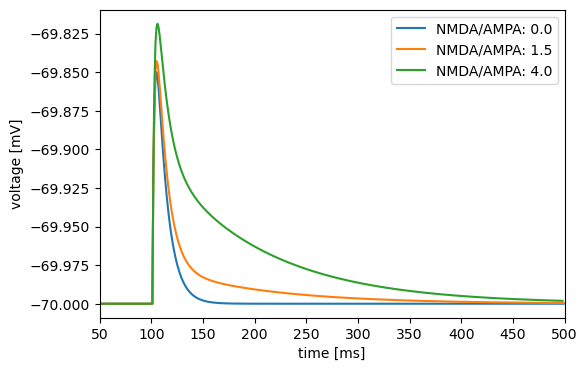

In [11]:
# plot simulated PSP and estimated PSP
plt.figure(figsize=(6,4))
plt.plot(times_post1, voltages_post1, label='NMDA/AMPA: 0.0')
plt.plot(times_post2, voltages_post2,label='NMDA/AMPA: 1.5')
plt.plot(times_post3, voltages_post3,label='NMDA/AMPA: 4.0')
plt.ylabel('voltage [mV]')
plt.xlabel('time [ms]')
plt.xlim(50,500)
plt.legend()
plt.show()

In [12]:
nest.GetStatus(mult)[0]['events']['times'][0:-1:3]

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15